In [46]:
import pandas as pd
import json
from environs import Env
from neo4j import GraphDatabase
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import operator
import requests
import math

In [179]:
env = Env()
env.read_env()

EPIGRAPHDB_SERVER = env.str("EPIGRAPHDB_SERVER")
EPIGRAPHDB_USER = "neo4j"
EPIGRAPHDB_PORT = env.str("EPIGRAPHDB_PORT")
EPIGRAPHDB_PASSWORD = env.str("EPIGRAPHDB_PASSWORD")
print(EPIGRAPHDB_PORT)

epigraphdb_driver = GraphDatabase.driver(
    "bolt://{server_name}:{port}".format(
        server_name=EPIGRAPHDB_SERVER, port=EPIGRAPHDB_PORT),
    auth=(EPIGRAPHDB_USER, EPIGRAPHDB_PASSWORD))

session = epigraphdb_driver.session()

37687


In [3]:
def query_to_df(query):
    print(query)
    data=session.run(query).data()
    df = pd.json_normalize(data)
    return(df)

#### In this notebook:

- Review all available breast cancer GWAS
- Try pathwasy connections GWAS -> Pathways
    - comparison between full/ER+/ER-
- Try pathwasy connections GWAS -> Tissue
- Review Disease nodes
    - mapping to EFO
    - EFO to GWAS
    - review EFO of largest BC GWAS
- MR 
- Correlations
- First look at literature data
    - predicates?
    - GWAS to Disease via literature nodes

    

## Get GWAS with available full summary data

In [137]:
query="""
MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author
order by gwas_to_variant.samplesize desc
"""
df = query_to_df(query)
df


MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)
where toLower(gwas.trait) contains "breast"
return distinct gwas.trait, gwas.id, gwas_to_variant.samplesize as SampleSize,
toInteger(gwas.ncase) as N_case, toInteger(gwas.ncontrol) as N_control, gwas.author
order by gwas_to_variant.samplesize desc



,gwas.trait,gwas.id,SampleSize,N_case,N_control,gwas.author
0,Diagnoses - main ICD10: C50 Malignant neoplasm...,ukb-a-519,337199,5510,331689,Neale
1,Cancer code self-reported: breast cancer,ukb-a-55,337159,7480,329679,Neale
2,Illnesses of mother: Breast cancer,ukb-a-213,308780,25865,283784,Neale
3,Breastfed as a baby,ukb-a-33,255881,181621,74260,Neale
4,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,228951,122977,105974,Michailidou K
5,ER+ Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1127,175475,69501,105974,Michailidou K
6,ER- Breast cancer (Combined Oncoarray; iCOGS; ...,ieu-a-1128,127442,21468,105974,Michailidou K
7,Breast cancer (Oncoarray),ieu-a-1129,106776,61282,45494,Michailidou K
8,Breast cancer (iCOGS),ieu-a-1130,89677,46785,42892,Michailidou K
9,ER+ Breast cancer (Oncoarray),ieu-a-1132,83691,38197,45494,Michailidou K


## Test gwas->variant->gene->protein->pathway

In [151]:
# for major GWAS

def get_gwas_to_pathway(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = '{gwas_id}' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, gwas_to_variant.samplesize as sampleSize,
           variant.name, gene.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY gwas_to_variant.pval
    """.format(gwas_id=GWAS_ID)

    df = query_to_df(query)
    return df

bc_all = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1126')
print(bc_all.shape[0])
bc_er_pos = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1127')
print(bc_er_pos.shape[0])
bc_er_neg = get_gwas_to_pathway(GWAS_ID = 'ieu-a-1128')
print(bc_er_neg.shape[0])



    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = 'ieu-a-1126' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, gwas_to_variant.samplesize as sampleSize,
           variant.name, gene.name, protein.uniprot_id, 
           collect (pathway.name) as Pathways, count (pathway.name) as N_pathways 
    ORDER BY gwas_to_variant.pval
    
53

    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
    WHERE gwas.id = 'ieu-a-1127' AND gwas_to_variant.pval < 1e-08 
    AND gene.name is not null 
    RETURN gwas.id, gwas_to_variant.be

In [154]:
bc_all[bc_all['gene.name']=='ESR1']

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
4,ieu-a-1126,0.0663,1.307073e-26,228951,rs2747652,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34
18,ieu-a-1126,0.1352,1.270867e-13,228951,rs76956704,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34


In [155]:
bc_er_pos[bc_er_pos['gene.name']=='ESR1']

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
11,ieu-a-1127,0.1107,6.668068e-14,175475,rs6904031,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34


In [156]:
bc_er_neg[bc_er_neg['gene.name']=='ESR1']

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
4,ieu-a-1128,0.0991,1.926194e-18,127442,rs2747652,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34
12,ieu-a-1128,0.2193,1.494858e-11,127442,rs76956704,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34


In [161]:
list(bc_er_pos[bc_er_pos['gene.name']=='ESR1']['Pathways'])

[['Estrogen-dependent gene expression',
  'Extra-nuclear estrogen signaling',
  'Signaling by Receptor Tyrosine Kinases',
  'Signaling by Nuclear Receptors',
  'Intracellular signaling by second messengers',
  'Regulation of RUNX2 expression and activity',
  'RUNX1 regulates transcription of genes involved in WNT signaling',
  'ESR-mediated signaling',
  'RUNX1 regulates estrogen receptor mediated transcription',
  'Transcriptional regulation by RUNX1',
  'Transcriptional regulation by RUNX2',
  'TFAP2 (AP-2) family regulates transcription of growth factors and their receptors',
  'Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors',
  'Gene expression (Transcription)',
  'RNA Polymerase II Transcription',
  'PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling',
  'Post-translational protein modification',
  'Ovarian tumor domain proteases',
  'Deubiquitination',
  'Diseases of signal transduction by growth factor receptors and second messengers',
  'SUMOylation

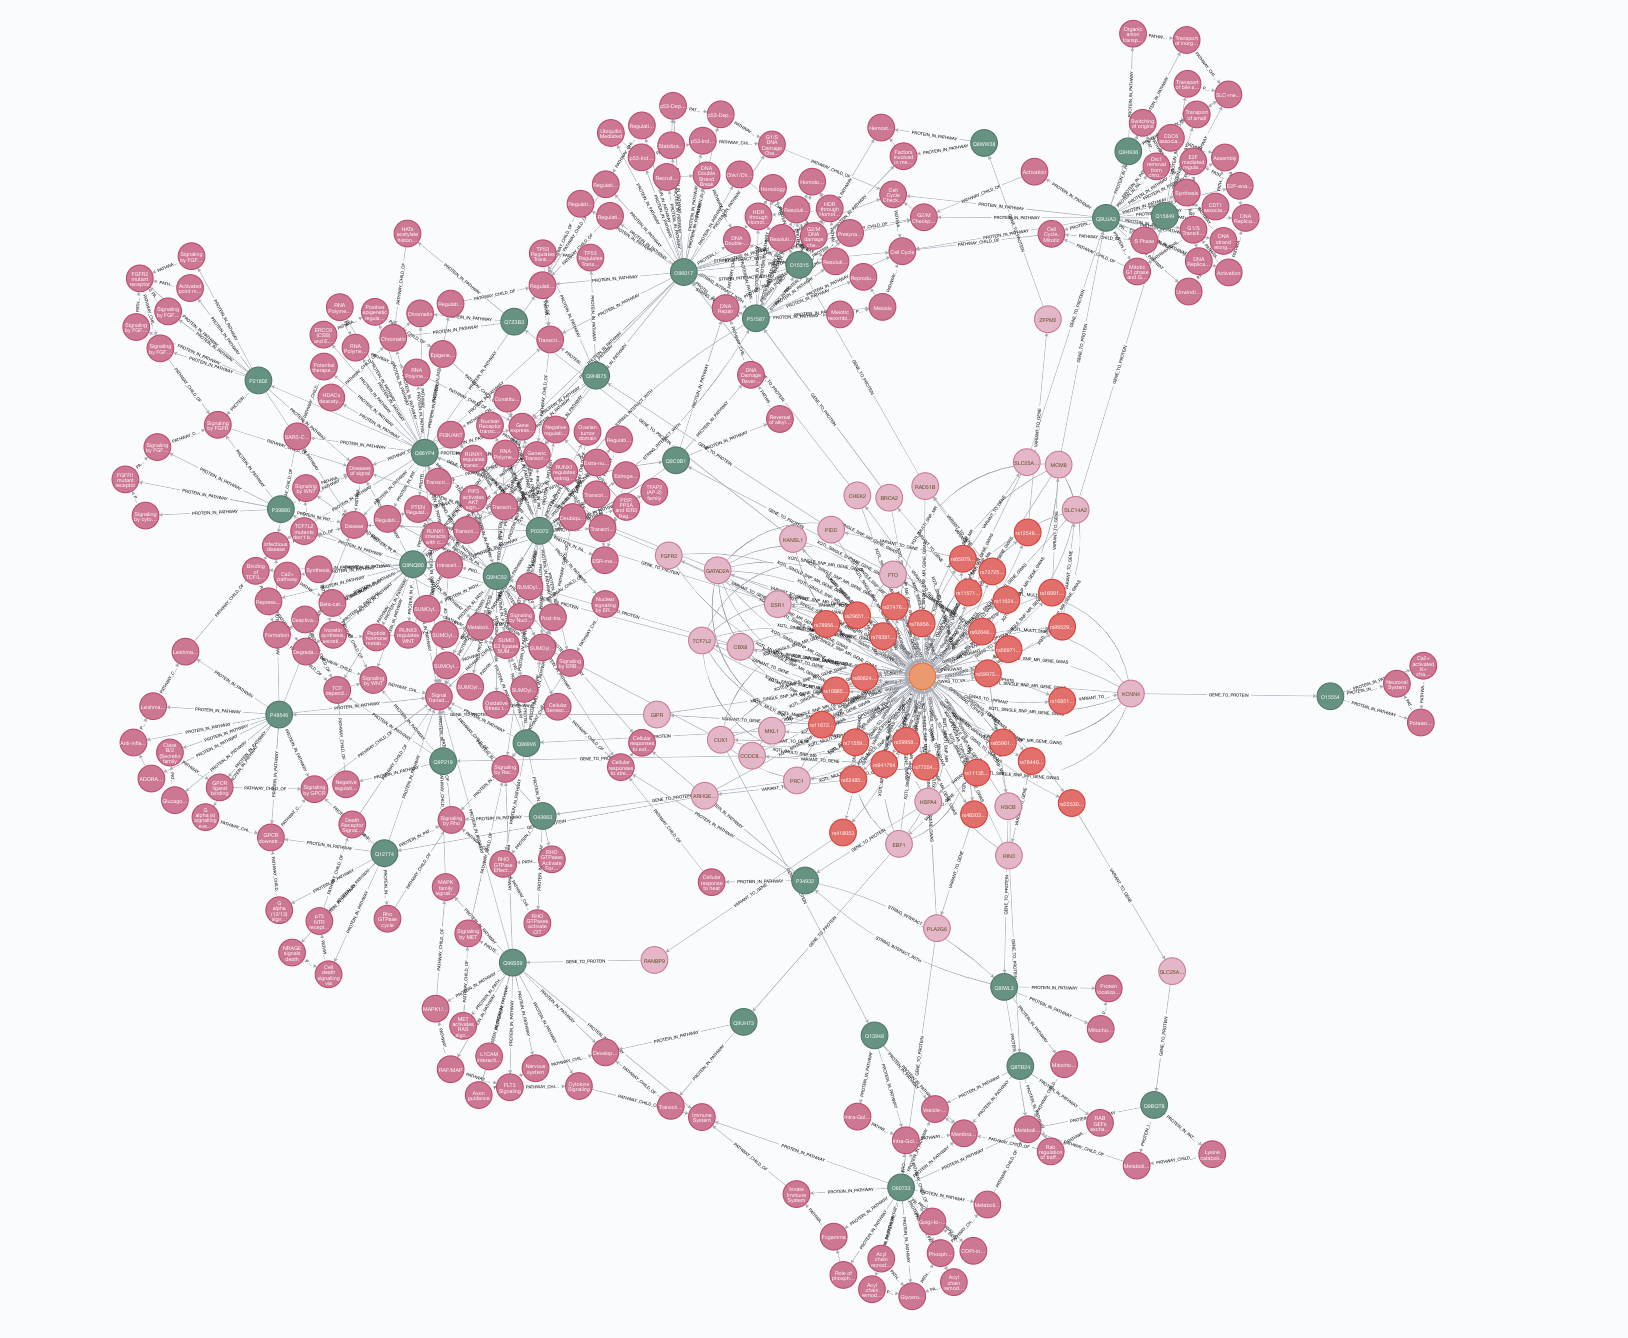

In [141]:
# for neo4j browser to make a viz

#MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_protein:GENE_TO_PROTEIN]->(protein:Protein) -[protein_in_pathway:PROTEIN_IN_PATHWAY]->(pathway:Pathway) 
#WHERE gwas.id = 'ieu-a-1126' AND gwas_to_variant.pval < 1e-08 
#AND gene.name is not null 
#RETURN gwas, gwas_to_variant, variant,variant_to_gene,  gene, gene_to_protein, protein, protein_in_pathway, pathway

from IPython.display import Image
Image(filename = "ieu-a-1126_pathways.png")

In [73]:
bc_all

,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,sampleSize,variant.name,gene.name,protein.uniprot_id,Pathways,N_pathways
0,ieu-a-1126,-0.2030,1.000000e-200,228951,rs7895676,FGFR2,P21802,"[Signaling by FGFR2 fusions, Signaling by FGFR...",9
1,ieu-a-1126,-0.0968,6.501297e-42,228951,rs11624333,RAD51B,O15315,[Factors involved in megakaryocyte development...,12
2,ieu-a-1126,0.1206,9.038576e-35,228951,rs5995875,MKL1,Q969V6,"[Post-translational protein modification, RHO ...",9
3,ieu-a-1126,-0.0717,4.680584e-31,228951,rs11135046,EBF1,Q9UH73,[Transcriptional regulation of white adipocyte...,2
4,ieu-a-1126,0.0663,1.307073e-26,228951,rs2747652,ESR1,P03372,"[Estrogen-dependent gene expression, Extra-nuc...",34
5,ieu-a-1126,-0.0624,3.500258e-23,228951,rs62048402,FTO,Q9C0B1,[Reversal of alkylation damage by DNA dioxygen...,3
6,ieu-a-1126,-0.0651,4.046691e-21,228951,rs2853669,TERT,O14746,"[Chromosome Maintenance, Formation of the beta...",9
7,ieu-a-1126,-0.0615,2.381771e-20,228951,rs2506889,PEX14,O75381,"[Protein localization, Class I peroxisomal mem...",7
8,ieu-a-1126,-0.0586,3.874360e-20,228951,rs1685191,KCNN4,O15554,"[Potassium Channels, Ca2+ activated K+ channel...",3
9,ieu-a-1126,0.0567,9.074026e-19,228951,rs6787391,ITPR1,Q14643,"[Signaling by the B Cell Receptor (BCR), Antig...",50


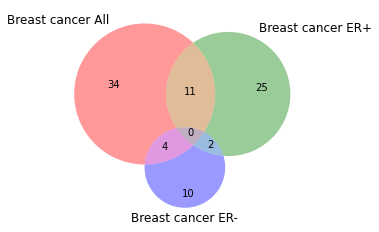

In [107]:
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
%matplotlib inline

# variants
venn3([set(bc_all["variant.name"]), set(bc_er_pos["variant.name"]), set(bc_er_neg["variant.name"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()

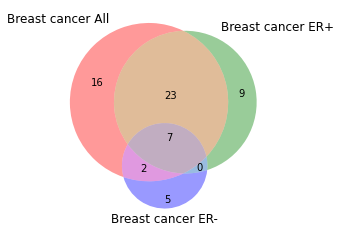

In [108]:
#genes
venn3([set(bc_all["gene.name"]), set(bc_er_pos["gene.name"]), set(bc_er_neg["gene.name"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()

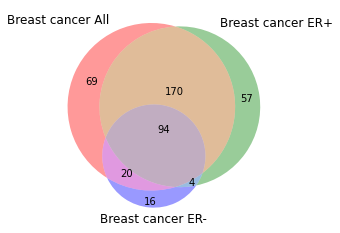

In [118]:
# pathways
def flatten(nested_list):
    flat_list = [item for sublist in list(nested_list) for item in sublist]
    return set(flat_list)

venn3([flatten(bc_all["Pathways"]),
      flatten(bc_er_pos["Pathways"]), 
      flatten(bc_er_neg["Pathways"])],
      set_labels=('Breast cancer All', 'Breast cancer ER+', 'Breast cancer ER-'))
plt.show()


## Test gwas->variant->gene->tissue (expressed in)

In [112]:
# for the main GWAS

# find GWAS variants pval < 1e-05, map to genes, get expression data,
# find which are expressed in Breast tissue, with TPM > 1

def get_gwas_to_tissue(GWAS_ID):
    query = """
    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gwas.id = '{gwas_id}' 
    AND gwas_to_variant.pval < 1e-05 
    AND gene.name is not null 
    AND gene_to_tissue.tpm > 1
    AND  tissue.name = "Breast - Mammary Tissue"
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, 
    variant.name, gene.name, 
    gene_to_tissue.tpm, tissue.name
    ORDER BY gene_to_tissue.tpm desc
    """.format(gwas_id=GWAS_ID)

    df = query_to_df(query)
    return df

bc_all_exp = get_gwas_to_tissue(GWAS_ID = 'ieu-a-1126')
bc_all_exp


    MATCH (gwas:Gwas) -[gwas_to_variant:GWAS_TO_VARIANT]->(variant:Variant)-[variant_to_gene:VARIANT_TO_GENE]-> (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gwas.id = 'ieu-a-1126' 
    AND gwas_to_variant.pval < 1e-05 
    AND gene.name is not null 
    AND gene_to_tissue.tpm > 1
    AND  tissue.name = "Breast - Mammary Tissue"
    RETURN gwas.id, gwas_to_variant.beta, gwas_to_variant.pval, 
    variant.name, gene.name, 
    gene_to_tissue.tpm, tissue.name
    ORDER BY gene_to_tissue.tpm desc
    


,gwas.id,gwas_to_variant.beta,gwas_to_variant.pval,variant.name,gene.name,gene_to_tissue.tpm,tissue.name
0,ieu-a-1126,0.0450,1.205869e-11,rs12487185,TGFBR2,273.1000,Breast - Mammary Tissue
1,ieu-a-1126,0.1010,3.793150e-13,rs35383942,PHLDA3,118.1500,Breast - Mammary Tissue
2,ieu-a-1126,-0.0468,2.930218e-12,rs6725517,ADCY3,57.2800,Breast - Mammary Tissue
3,ieu-a-1126,0.0365,5.768063e-09,rs12519859,SUB1,52.6700,Breast - Mammary Tissue
4,ieu-a-1126,-0.0725,2.788688e-28,rs7258465,SSBP4,43.8950,Breast - Mammary Tissue
...,...,...,...,...,...,...,...
78,ieu-a-1126,-0.0968,6.501297e-42,rs11624333,RAD51B,1.6270,Breast - Mammary Tissue
79,ieu-a-1126,0.0559,3.875252e-11,rs72725173,RAD51B,1.6270,Breast - Mammary Tissue
80,ieu-a-1126,0.0462,5.408789e-12,rs35910339,ASTN2,1.5045,Breast - Mammary Tissue
81,ieu-a-1126,0.1046,1.612130e-63,rs7626742,NEK10,1.2100,Breast - Mammary Tissue


In [113]:
genes_test=list(bc_all_exp['gene.name'])

query = """
    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name in {} 
    AND gene_to_tissue.tpm > 1
    WITH gene_to_tissue, gene, tissue
    ORDER BY gene_to_tissue.tpm  desc, tissue.name
    RETURN gene.name, count(tissue.name) as N_tissues, 
    collect(tissue.name) as Tissues, collect(gene_to_tissue.tpm) as TPM_vals
    """.format(genes_test)

df = query_to_df(query)
df


    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name in ['TGFBR2', 'PHLDA3', 'ADCY3', 'SUB1', 'SSBP4', 'KRTCAP2', 'AMFR', 'TCF7L2', 'ZMIZ1', 'ZMIZ1', 'EBF1', 'RANBP9', 'HSPA4', 'PIK3R3', 'MKL1', 'KANSL1', 'LSP1', 'PLA2G6', 'DNAJC1', 'PEX14', 'GATAD2A', 'FILIP1L', 'HSCB', 'N4BP2L1', 'PIDD', 'MLLT10', 'RNF115', 'GRHL1', 'ZBTB38', 'ITPR1', 'LINC-PINT', 'ATXN7', 'SLC25A22', 'VGLL3', 'FAM46A', 'MTMR11', 'CMSS1', 'TTC28', 'SETBP1', 'RIN3', 'RP11-134G8.8', 'RCCD1', 'CCDC88C', 'CUX1', 'GIPR', 'FGFR2', 'OTUD7B', 'KCNN4', 'L3MBTL3', 'ADSSL1', 'CASP8', 'FTO', 'FTO', 'CREB5', 'CDCA7L', 'GAREM', 'ZFPM2', 'MAGI3', 'ESR1', 'ESR1', 'TET2', 'MCM8', 'LMX1B', 'ARHGEF5', 'CDYL2', 'CHEK2', 'FAM175A', 'MYEOV', 'ABO', 'PRC1', 'PDE4D', 'ATG10', 'NREP', 'TLR1', 'CBX8', 'OR2A1-AS1', 'STXBP4', 'ATAD5', 'RAD51B', 'RAD51B', 'ASTN2', 'NEK10', 'TRIM46'] 
    AND gene_to_tissue.tpm > 1
    WITH gene_to_tissue, gene, tissue
    ORDER BY gene_to_tissue.tpm  desc, tissue.name
    RE

,gene.name,N_tissues,Tissues,TPM_vals
0,LSP1,42,"[Whole Blood, Cells - EBV-transformed lymphocy...","[418.8, 236.7, 165.85, 105.15, 57.02, 53.04, 4..."
1,PHLDA3,51,"[Nerve - Tibial, Colon - Sigmoid, Adipose - Su...","[352.75, 195.0, 183.15, 118.15, 117.8, 113.9, ..."
2,TGFBR2,52,"[Adipose - Subcutaneous, Adipose - Visceral (O...","[316.8, 296.1, 273.1, 260.05, 252.3, 244.4, 22..."
3,ADSSL1,50,"[Muscle - Skeletal, Artery - Tibial, Artery - ...","[311.15, 63.53, 58.37, 54.49, 52.2, 44.51, 19...."
4,FILIP1L,48,"[Artery - Aorta, Artery - Tibial, Artery - Cor...","[186.1, 131.8, 94.99, 67.04, 64.805, 59.84, 58..."
...,...,...,...,...
74,OR2A1-AS1,24,"[Thyroid, Skin - Sun Exposed (Lower leg), Skin...","[9.059, 4.535, 4.527, 3.0215, 2.9425, 2.756999..."
75,ATG10,51,"[Testis, Skin - Not Sun Exposed (Suprapubic), ...","[6.895, 3.824, 3.7855, 3.7560000000000002, 3.6..."
76,LMX1B,8,"[Breast - Mammary Tissue, Skin - Sun Exposed (...","[5.348, 3.0789999999999997, 2.763, 2.68, 2.498..."
77,RAD51B,21,"[Uterus, Cells - EBV-transformed lymphocytes, ...","[5.187, 4.0765, 3.2539999999999996, 3.19100000..."


In [53]:
query = """
    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name = 'ATG10' 
    AND gene_to_tissue.tpm > 1
    RETURN gene.name, gene_to_tissue.tpm, tissue.name 
    ORDER BY gene_to_tissue.tpm desc
    """

df = query_to_df(query)
df


    MATCH (gene:Gene)-[gene_to_tissue:EXPRESSED_IN]->(tissue:Tissue) 
    WHERE gene.name = 'ATG10' 
    AND gene_to_tissue.tpm > 1
    RETURN gene.name, gene_to_tissue.tpm, tissue.name 
    ORDER BY gene_to_tissue.tpm desc
    


,gene.name,gene_to_tissue.tpm,tissue.name
0,ATG10,6.8950,Testis
1,ATG10,3.8240,Skin - Not Sun Exposed (Suprapubic)
2,ATG10,3.7855,Thyroid
3,ATG10,3.7560,Bladder
4,ATG10,3.6950,Skin - Sun Exposed (Lower leg)
5,ATG10,3.5060,Nerve - Tibial
6,ATG10,3.4960,Cervix - Ectocervix
7,ATG10,3.4660,Artery - Aorta
8,ATG10,3.4510,Artery - Tibial
9,ATG10,3.3460,Uterus


## Looking for 'breast-related' diseases

In [54]:
# just matching key word
query="""
MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label
"""
df = query_to_df(query)
df


MATCH (disease:Disease)
where toLower(disease.label) contains 'breast'
return distinct disease.label



,disease.label
0,malignant breast melanoma
1,"breast-ovarian cancer, familial, susceptibilit..."
2,HER2 positive breast carcinoma
3,lobular breast carcinoma in situ
4,breast rhabdomyosarcoma
...,...
161,estrogen-receptor negative breast cancer
162,invasive lobular breast carcinoma
163,ductal breast carcinoma in situ
164,medullary breast carcinoma


### Get 'breast' diseases with EFO mapping

In [76]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo.value order by disease.label
"""
df = query_to_df(query)
df


MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo.value order by disease.label



,disease.label,efo.id,efo.value
0,HER2 positive breast carcinoma,http://www.ebi.ac.uk/efo/EFO_1000294,HER2 Positive Breast Carcinoma
1,acantholytic variant squamous cell breast carc...,http://www.ebi.ac.uk/efo/EFO_1001969,"squamous cell breast carcinoma, acantholytic v..."
2,adenoid cystic breast carcinoma,http://www.ebi.ac.uk/efo/EFO_1000071,Adenoid Cystic Breast Carcinoma
3,atypical lobular breast hyperplasia,http://www.ebi.ac.uk/efo/EFO_1000100,Atypical Lobular Breast Hyperplasia
4,basal-like breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000281,basal-like carcinoma
5,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma
6,breast adenosis,http://www.ebi.ac.uk/efo/EFO_0006891,breast adenosis
7,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma
8,breast carcinoma by gene expression profile,http://www.ebi.ac.uk/efo/EFO_1000143,Breast Carcinoma by Gene Expression Profile
9,breast cyst,http://www.ebi.ac.uk/efo/EFO_1000848,breast cyst


## Disease -> EFO -> GWAS 

In [151]:
query="""
MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo_to_gwas.score, gwas.id, gwas.trait, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by gwas.id
"""
df = query_to_df(query)
df


MATCH (disease:Disease)-[disease_to_efo:MONDO_MAP_EFO]->(efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(disease.label) contains 'breast'
return  disease.label, efo.id, efo_to_gwas.score, gwas.id, gwas.trait, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by gwas.id



,disease.label,efo.id,efo_to_gwas.score,gwas.id,gwas.trait,N,n_case
0,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,0.852600,ebi-a-GCST004988,Breast cancer,139274.0,76192
1,triple-negative breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0005537,0.778631,ebi-a-GCST004988,Breast cancer,139274.0,76192
2,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,0.734440,ebi-a-GCST004988,Breast cancer,139274.0,76192
3,invasive ductal breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000186,0.709351,ebi-a-GCST004988,Breast cancer,139274.0,76192
4,invasive breast carcinoma,http://www.ebi.ac.uk/efo/EFO_1000307,0.726793,ebi-a-GCST004988,Breast cancer,139274.0,76192
...,...,...,...,...,...,...,...
79,breast neoplasm,http://www.ebi.ac.uk/efo/EFO_0003869,0.843308,ukb-b-8549,Diagnoses - main ICD10: D24 Benign neoplasm of...,463010.0,1244
80,breast neoplasm,http://www.ebi.ac.uk/efo/EFO_0003869,0.819933,ukb-d-C3_BREAST_3,Malignant neoplasm of breast,361194.0,9721
81,ductal breast carcinoma in situ,http://www.ebi.ac.uk/efo/EFO_0000432,0.870516,ukb-d-D05,Diagnoses - main ICD10: D05 Carcinoma in situ ...,361194.0,1454
82,lobular breast carcinoma in situ,http://www.ebi.ac.uk/efo/EFO_1000326,0.828606,ukb-d-D05,Diagnoses - main ICD10: D05 Carcinoma in situ ...,361194.0,1454


## Find what EFO the largest breast cancer GWAS are mapped to

In [80]:
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  
        count (efo.value) as N_EFO, toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values,  count (efo.value) as N_EFO, 
        toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case 
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case
0,prot-a-234,Breast cancer anti-estrogen resistance protein 3,[http://www.ebi.ac.uk/efo/EFO_0008040],[breast cancer anti-estrogen resistance protei...,1,3301.0,NaN
1,ebi-a-GCST004988,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,139274.0,76192.0
2,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",7,106776.0,61282.0
3,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
4,ebi-a-GCST007236,Breast cancer,"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",13,89677.0,46785.0
5,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",11,89677.0,46785.0
6,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691.0,38197.0
7,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
8,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000649, http://...","[estrogen-receptor positive breast cancer, est...",2,69970.0,27078.0
9,ukb-b-16890,"Cancer code, self-reported: breast cancer","[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, cancer, estrogen-receptor p...",3,462933.0,10303.0


In [85]:
# now look only at 'ieu-a' GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc
"""
df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id starts with 'ieu-a' and toLower(gwas.trait) contains 'breast'
return gwas.id, gwas.trait,  collect(efo.id) as EFO_IDs, collect (efo.value) as EFO_values, count (efo.value) as N_EFO,
       toInteger(gwas.sample_size) as N, toInteger(gwas.ncase) as n_case , toInteger(gwas.year) as year
order by toInteger(gwas.ncase) desc



,gwas.id,gwas.trait,EFO_IDs,EFO_values,N_EFO,N,n_case,year
0,ieu-a-1129,Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, Her...",7,106776,61282,2017
1,ieu-a-1130,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2017
2,ieu-a-1162,Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0000281, http://...","[basal-like carcinoma, breast ductal adenocarc...",11,89677,46785,2015
3,ieu-a-1132,ER+ Breast cancer (Oncoarray),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,83691,38197,2017
4,ieu-a-1133,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2017
5,ieu-a-1161,ER+ Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_1000650, http://...","[estrogen-receptor negative breast cancer, est...",2,69970,27078,2015
6,ieu-a-1135,ER- Breast cancer (Oncoarray),"[http://www.ebi.ac.uk/efo/EFO_0000305, http://...","[breast carcinoma, triple-negative breast canc...",4,55149,9655,2017
7,ieu-a-1136,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2017
8,ieu-a-1160,ER- Breast cancer (iCOGS),"[http://www.ebi.ac.uk/efo/EFO_0005607, http://...","[breast cancer stage, basal-like carcinoma, br...",6,50225,7333,2015
9,ieu-a-1163,ER- Breast cancer (Survival),[http://www.ebi.ac.uk/efo/EFO_1000649],[estrogen-receptor positive breast cancer],1,6881,920,2015


In [92]:
# showing the EFO assignments for the next largest GWAS
query="""
MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
SET gwas.name = gwas.`_name`
SET efo.name = efo.`_name`
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id"""

df = query_to_df(query)
df


MATCH (efo:Efo)<-[efo_to_gwas:GWAS_NLP_EFO]-(gwas:Gwas)
where gwas.id in ['ieu-a-1129', 'ieu-a-1132', 'ieu-a-1135']
return gwas.id,gwas.trait,  efo.id, efo.value, efo_to_gwas.score
order by gwas.id


,gwas.id,gwas.trait,efo.id,efo.value,efo_to_gwas.score
0,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer,0.701004
1,ieu-a-1129,Breast cancer (Oncoarray),http://www.orpha.net/ORDO/Orphanet_227535,Hereditary breast cancer,0.702555
2,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma,0.710287
3,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005607,breast cancer stage,0.713407
4,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.715045
5,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.737351
6,ieu-a-1129,Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.801407
7,ieu-a-1132,ER+ Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer,0.718764
8,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma,0.732981
9,ieu-a-1135,ER- Breast cancer (Oncoarray),http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast cancer,0.743182


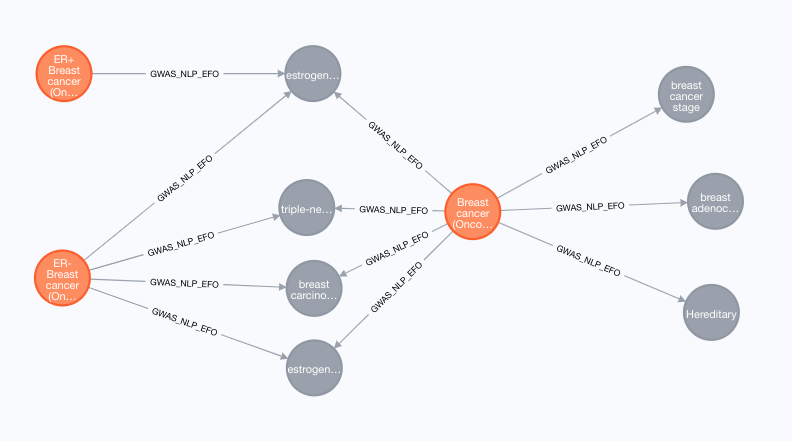

In [55]:
from IPython.display import Image
Image(filename = "gwas_efo.png", width = 800)

##  Disease label =  EFO ?  and GWAS name

In [93]:
# is it alaways same as EFO?
query="""
MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc
"""

df = query_to_df(query)
df


MATCH (gwas:Gwas)-[gwas_to_efo:GWAS_NLP_EFO]->(efo:Efo)<-[efo_disease:MONDO_MAP_EFO]-(disease:Disease) 
WHERE gwas_to_efo.score > 0.5 AND gwas.id = "ieu-a-1129" 
RETURN gwas.id, gwas.trait, gwas_to_efo.score,  efo.value, efo.id,  disease.label 
order by gwas_to_efo.score desc



,gwas.id,gwas.trait,gwas_to_efo.score,efo.value,efo.id,disease.label
0,ieu-a-1129,Breast cancer (Oncoarray),0.801407,breast carcinoma,http://www.ebi.ac.uk/efo/EFO_0000305,breast carcinoma
1,ieu-a-1129,Breast cancer (Oncoarray),0.737351,estrogen-receptor positive breast cancer,http://www.ebi.ac.uk/efo/EFO_1000649,estrogen-receptor positive breast cancer
2,ieu-a-1129,Breast cancer (Oncoarray),0.715045,triple-negative breast cancer,http://www.ebi.ac.uk/efo/EFO_0005537,triple-negative breast carcinoma
3,ieu-a-1129,Breast cancer (Oncoarray),0.710287,breast adenocarcinoma,http://www.ebi.ac.uk/efo/EFO_0000304,breast adenocarcinoma
4,ieu-a-1129,Breast cancer (Oncoarray),0.701004,estrogen-receptor negative breast cancer,http://www.ebi.ac.uk/efo/EFO_1000650,estrogen-receptor negative breast cancer


## MR data

In [61]:
# MR
query = """
MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id = "ieu-a-1126"  
AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-08
RETURN exposure {.id, .trait}, outcome.id, mr {.b, .pval, .method, .selection, .moescore} ORDER BY mr.pval
"""
df = query_to_df(query)
df


MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id = "ieu-a-1126"  
AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-08
RETURN exposure {.id, .trait}, outcome.id, mr {.b, .pval, .method, .selection, .moescore} ORDER BY mr.pval



,outcome.id,exposure.trait,exposure.id,mr.b,mr.method,mr.selection,mr.pval,mr.moescore
0,ieu-a-1126,Non-cancer illness code self-reported: osteoa...,ukb-a-106,1.778924,FE IVW,DF,1.041688e-298,1
1,ieu-a-1126,Mineral and other dietary supplements: Glucosa...,ukb-a-494,-0.133423,FE IVW,DF,5.154322e-35,1
2,ieu-a-1126,Diagnoses - main ICD10: R14 Flatulence and rel...,ukb-a-584,12.411659,FE IVW,DF,6.556335e-31,1
3,ieu-a-1126,Average weekly champagne plus white wine intake,ukb-a-27,-0.591364,FE IVW,DF,3.926666e-30,1
4,ieu-a-1126,Non-cancer illness code self-reported: pernic...,ukb-a-90,5.220976,FE IVW,DF,3.364830e-26,1
5,ieu-a-1126,Reason for glasses/contact lenses: For just re...,ukb-a-421,2.099325,FE IVW,DF,9.570221e-16,1
6,ieu-a-1126,Waist circumference,ieu-a-102,-0.642405,FE IVW,DF,1.990503e-14,1
7,ieu-a-1126,Diagnoses - main ICD10: I84 Haemorrhoids,ukb-a-539,6.393298,FE IVW,DF,1.474239e-13,1
8,ieu-a-1126,Body mass index,ieu-a-974,-0.788037,FE Egger,HF,9.788118e-13,0.76
9,ieu-a-1126,Non-cancer illness code self-reported: type 2...,ukb-a-75,14.578263,FE IVW,DF,1.636759e-12,1


In [85]:
# MR
# look at 3 GWAS; 1e-05, group

GWAS_IDS = ['ieu-a-1126', 'ieu-a-1127', 'ieu-a-1128']
query = """
MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id in {} 
AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-05
with mr, exposure, outcome
ORDER BY mr.pval 
RETURN exposure.id, exposure.trait,collect(outcome.id) as outcome_ids, collect(mr.pval) as MR_pvals, exposure.sample_size
""".format(GWAS_IDS)
df = query_to_df(query)

df


MATCH (exposure:Gwas)-[mr:MR_EVE_MR]->(outcome:Gwas)
WHERE outcome.id in ['ieu-a-1126', 'ieu-a-1127', 'ieu-a-1128'] 
AND (not (toLower(exposure.trait) contains 'breast')) 
AND mr.pval < 1e-05
with mr, exposure, outcome
ORDER BY mr.pval 
RETURN exposure.id, exposure.trait,collect(outcome.id) as outcome_ids, collect(mr.pval) as MR_pvals, exposure.sample_size



,exposure.id,exposure.trait,outcome_ids,MR_pvals,exposure.sample_size
0,ukb-a-141,Treatment/medication code: prednisolone,"[ieu-a-1127, ieu-a-1126]","[0.0, 5.62662360567798e-06]",337159.0
1,ukb-a-106,Non-cancer illness code self-reported: osteoa...,[ieu-a-1126],[1.04168824827867e-298],337159.0
2,ukb-a-552,Diagnoses - main ICD10: K50 Crohn's disease [r...,[ieu-a-1128],[6.96684506740202e-296],337199.0
3,ukb-a-531,Diagnoses - main ICD10: I10 Essential (primary...,[ieu-a-1127],[4.93797276666824e-227],337199.0
4,ukb-a-584,Diagnoses - main ICD10: R14 Flatulence and rel...,"[ieu-a-1127, ieu-a-1126]","[8.1950123066024e-57, 6.55633521331685e-31]",337199.0
5,ukb-a-564,Diagnoses - main ICD10: M20 Acquired deformiti...,[ieu-a-1128],[2.21581458567691e-47],337199.0
6,ukb-a-75,Non-cancer illness code self-reported: type 2...,"[ieu-a-1127, ieu-a-1126]","[1.62841918660626e-40, 1.63675940962885e-12]",337159.0
7,ukb-a-494,Mineral and other dietary supplements: Glucosa...,"[ieu-a-1126, ieu-a-1128]","[5.1543215295548e-35, 3.36184775718076e-19]",336314.0
8,ukb-a-27,Average weekly champagne plus white wine intake,[ieu-a-1126],[3.9266661041497e-30],240864.0
9,ukb-a-149,Treatment/medication code: doxazosin,[ieu-a-1128],[5.24520716571918e-30],337159.0


## Correlations

In [86]:
# there are no breast cancer traits in gen corrs 
query = """
MATCH (trait:Gwas)-[gen_cor:GEN_COR]-(assoc_trait:Gwas)
where toLower(trait.trait) contains "breast"
return distinct trait.trait, trait.id
"""
df = query_to_df(query)
df


MATCH (trait:Gwas)-[gen_cor:GEN_COR]-(assoc_trait:Gwas)
where toLower(trait.trait) contains "breast"
return distinct trait.trait, trait.id



,trait.trait,trait.id
0,Malignant neoplasm of breast,ukb-d-C3_BREAST_3
1,Diagnoses - main ICD10: C50 Malignant neoplasm...,ukb-a-519
2,Breastfed as a baby,ukb-b-13423
3,Breastfed as a baby,ukb-a-33


In [87]:
# there are no breast cancer traits in obs corrs 
query = """
MATCH (trait:Gwas)-[obs_cor:OBS_COR]-(assoc_trait:Gwas)
where toLower(trait.trait)contains "breast "
return distinct trait.trait, trait.id
"""
df = query_to_df(query)
df


MATCH (trait:Gwas)-[obs_cor:OBS_COR]-(assoc_trait:Gwas)
where toLower(trait.trait)contains "breast "
return distinct trait.trait, trait.id



,trait.trait,trait.id
0,Illnesses of mother: Breast cancer,ukb-b-13584


In [139]:
# there are no breast cancer traits in PRS
query = """
MATCH (trait:Gwas)-[prs:PRS]-(assoc_trait:Gwas)
where toLower(trait.trait)contains "breast "
return distinct trait.trait, trait.id
"""
df = query_to_df(query)
df


MATCH (trait:Gwas)-[prs:PRS]-(assoc_trait:Gwas)
where toLower(trait.trait)contains "breast "
return distinct trait.trait, trait.id



,trait.trait,trait.id
0,Illnesses of mother: Breast cancer,ukb-a-213
1,Illnesses of mother: Breast cancer,ukb-b-13584
2,Cancer code self-reported: breast cancer,ukb-a-55


# Looking at literature connections

In [94]:
# get all types of predicate
query="""
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43
"""
df = query_to_df(query)
df


MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43



,triple.predicate
0,CAUSES
1,INTERACTS_WITH
2,INHIBITS
3,STIMULATES
4,PREVENTS
5,higher_than
6,COEXISTS_WITH
7,ASSOCIATED_WITH
8,CONVERTS_TO
9,NEG_CAUSES


### Example query GWAS - literature - GWAS

In [91]:
# Childhood obesity -> breast cancer

query="""
MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000
"""
df_obesity_lit = query_to_df(query)
df_obesity_lit



MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000



,gwas.id,gwas.trait,gwas_to_lit1.pval,s1.predicate,lit_term.name,s2.predicate,gwas_to_lit2.pval,assoc_gwas.id,assoc_gwas.trait
0,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,H3F3AP6,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
1,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,NSG1,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
2,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,TCEAL1,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
3,ieu-a-1096,Childhood obesity,8.204412e-06,INHIBITS,CDKN1A,STIMULATES,2.287763e-14,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
4,ieu-a-1096,Childhood obesity,8.204412e-06,ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
...,...,...,...,...,...,...,...,...,...
506,ieu-a-1096,Childhood obesity,4.543086e-07,COEXISTS_WITH,leptin,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
507,ieu-a-1096,Childhood obesity,8.847083e-13,COEXISTS_WITH,Insulin,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
508,ieu-a-1096,Childhood obesity,8.204412e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,9.004132e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
509,ieu-a-1096,Childhood obesity,8.204412e-06,COEXISTS_WITH,testosterone,INTERACTS_WITH,9.548222e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...


In [93]:

#ukb-b-4650	Comparative body size at age 10 -> breast cancer


query="""
MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ukb-b-4650" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000
"""
df_bodysize_lit = query_to_df(query)
df_bodysize_lit


MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ukb-b-4650" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000



,gwas.id,gwas.trait,gwas_to_lit1.pval,s1.predicate,lit_term.name,s2.predicate,gwas_to_lit2.pval,assoc_gwas.id,assoc_gwas.trait
0,ukb-b-4650,Comparative body size at age 10,2.232535e-07,NEG_ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
1,ukb-b-4650,Comparative body size at age 10,5.051966e-06,COEXISTS_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
2,ukb-b-4650,Comparative body size at age 10,2.044650e-06,ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
3,ukb-b-4650,Comparative body size at age 10,2.898941e-06,ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
4,ukb-b-4650,Comparative body size at age 10,7.810860e-07,NEG_ASSOCIATED_WITH,Obesity,PREDISPOSES,1.804619e-12,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
...,...,...,...,...,...,...,...,...,...
77,ukb-b-4650,Comparative body size at age 10,2.232535e-07,INTERACTS_WITH,LEP,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
78,ukb-b-4650,Comparative body size at age 10,2.232535e-07,INTERACTS_WITH,leptin,INTERACTS_WITH,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
79,ukb-b-4650,Comparative body size at age 10,2.232535e-07,INTERACTS_WITH,leptin,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...
80,ukb-b-4650,Comparative body size at age 10,1.443370e-62,COEXISTS_WITH,ethanol,STIMULATES,5.440435e-06,ieu-a-1126,Breast cancer (Combined Oncoarray; iCOGS; GWAS...


In [102]:
df_bodysize_lit.reset_index()['lit_term.name'].value_counts()



Obesity                 54
leptin                  10
LEP                      8
metformin                6
Hypertensive disease     2
ethanol                  2
Name: lit_term.name, dtype: int64

In [104]:
df_bodysize_lit['test'] = df_bodysize_lit['s1.predicate'] + " - "+ df_bodysize_lit['lit_term.name'] + " - "+ df_bodysize_lit['s2.predicate']
df_bodysize_lit.reset_index()['test'].value_counts()

TREATS - Obesity - PRODUCES                         10
TREATS - Obesity - PREDISPOSES                      10
INTERACTS_WITH - leptin - STIMULATES                 8
ASSOCIATED_WITH - Obesity - PRODUCES                 6
COEXISTS_WITH - Obesity - PRODUCES                   6
COEXISTS_WITH - Obesity - PREDISPOSES                6
ASSOCIATED_WITH - Obesity - PREDISPOSES              6
INTERACTS_WITH - LEP - STIMULATES                    6
higher_than - metformin - INHIBITS                   3
NEG_ASSOCIATED_WITH - Obesity - PREDISPOSES          3
NEG_ASSOCIATED_WITH - Obesity - PRODUCES             3
INTERACTS_WITH - leptin - INTERACTS_WITH             2
INTERACTS_WITH - LEP - INTERACTS_WITH                2
TREATS - Hypertensive disease - PREDISPOSES          1
PREDISPOSES - Hypertensive disease - PREDISPOSES     1
AFFECTS - Obesity - PREDISPOSES                      1
higher_than - metformin - COEXISTS_WITH              1
higher_than - metformin - STIMULATES                 1
COEXISTS_W

In [107]:
df_obesity_lit['test'] = df_obesity_lit['s1.predicate'] + " - "+ df_obesity_lit['lit_term.name'] + " - "+ df_obesity_lit['s2.predicate']
df_obesity_lit.reset_index()['test'].value_counts()

ASSOCIATED_WITH - Obesity - PREDISPOSES                 71
ASSOCIATED_WITH - Obesity - PRODUCES                    71
TREATS - Obesity - PRODUCES                             45
TREATS - Obesity - PREDISPOSES                          45
COEXISTS_WITH - Obesity - PRODUCES                      36
                                                        ..
INHIBITS - HDAC9 - INTERACTS_WITH                        1
NEG_COEXISTS_WITH - TRANCE protein - INTERACTS_WITH      1
ASSOCIATED_WITH - Hypertensive disease - PREDISPOSES     1
DISRUPTS - Obesity - PRODUCES                            1
COEXISTS_WITH - TGFB1 - CAUSES                           1
Name: test, Length: 70, dtype: int64

In [100]:
df_obesity_lit.reset_index()['lit_term.name'].value_counts()


Obesity                 430
leptin                   20
Hypertensive disease     12
LEP                       8
CDKN1A                    6
NSG1                      6
H3F3AP6                   6
Insulin                   6
TCEAL1                    6
TRANCE protein            2
folate                    2
testosterone              2
HDAC9                     1
TGFB1                     1
INS                       1
INSR                      1
TGFB1 protein, human      1
Name: lit_term.name, dtype: int64

In [122]:
#GENE_LIST = ['ATG10']
GENE_LIST = genes_test
query = """
        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in {gene_list}
        WITH  g,lt,l1,l2
        MATCH (lt)-[]-(lit:Literature) 
        RETURN l1.name as gene_as_litterm, lt.predicate as pred, l2.name as obj_as_litterm, lit.id ;
    """.format(gene_list=GENE_LIST)
df= query_to_df(query)
df


        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in ['TGFBR2', 'PHLDA3', 'ADCY3', 'SUB1', 'SSBP4', 'KRTCAP2', 'AMFR', 'TCF7L2', 'ZMIZ1', 'ZMIZ1', 'EBF1', 'RANBP9', 'HSPA4', 'PIK3R3', 'MKL1', 'KANSL1', 'LSP1', 'PLA2G6', 'DNAJC1', 'PEX14', 'GATAD2A', 'FILIP1L', 'HSCB', 'N4BP2L1', 'PIDD', 'MLLT10', 'RNF115', 'GRHL1', 'ZBTB38', 'ITPR1', 'LINC-PINT', 'ATXN7', 'SLC25A22', 'VGLL3', 'FAM46A', 'MTMR11', 'CMSS1', 'TTC28', 'SETBP1', 'RIN3', 'RP11-134G8.8', 'RCCD1', 'CCDC88C', 'CUX1', 'GIPR', 'FGFR2', 'OTUD7B', 'KCNN4', 'L3MBTL3', 'ADSSL1', 'CASP8', 'FTO', 'FTO', 'CREB5', 'CDCA7L', 'GAREM', 'ZFPM2', 'MAGI3', 'ESR1', 'ESR1', 'TET2', 'MCM8', 'LMX1B', 'ARHGEF5', 'CDYL2', 'CHEK2', 'FAM175A', 'MYEOV', 'ABO', 'PRC1', 'PDE4D', 'ATG10', 'NREP', 'TLR1', 'CBX8', 'OR2A1-AS1', 'STXBP4', 'ATAD5', 'RAD51B', 'RAD51B', 'ASTN2', 'NEK10', 'TRIM46']
        WITH  g,lt,l1,l2
        MATCH (lt)-[]-(lit:Literature) 
        RETURN l1.name 

,gene_as_litterm,pred,obj_as_litterm,lit.id
0,RCCD1,STIMULATES,LINC01419,31582214
1,RCCD1,COEXISTS_WITH,LINC01419,31582214
2,ITPR1,INHIBITS,PLN,30261161
3,ITPR1,INHIBITS,phospholamban,30261161
4,ITPR1,ASSOCIATED_WITH,Progressive cerebellar ataxia,21367767
...,...,...,...,...
35839,TGFBR2,INTERACTS_WITH,Transforming Growth Factor beta,31311317
35840,TGFBR2,INTERACTS_WITH,Transforming Growth Factor beta,26627606
35841,TGFBR2,INTERACTS_WITH,Transforming Growth Factor beta,17056535
35842,TGFBR2,INTERACTS_WITH,Transforming Growth Factor beta,10426193


In [134]:
#GENE_LIST = ['ATG10']

# Do not run full - too long

GENE_LIST = genes_test
query = """
        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)
        WHERE g.name in {gene_list}
        WITH  g,l1,lt1, l2, lt2, l3
        MATCH (lt1)-[]-(lit:Literature) 
        RETURN l1.name as term1, lt1.predicate as pred1, l2.name as term2 ,  lt2.predicate as pred2, l3.name as term3 , lit.id

    """.format(gene_list=GENE_LIST)
df= query_to_df(query)
df


        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)
        WHERE g.name in ['TGFBR2']
        WITH  g,l1,lt1, l2, lt2, l3
        MATCH (lt1)-[]-(lit:Literature) 
        RETURN l1.name as term1, lt1.predicate as pred1, l2.name as term2 ,  lt2.predicate as pred2, l3.name as term3 , lit.id

    


RuntimeError: generator raised StopIteration

In [148]:
gene_list = genes_test # tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit
query="""
MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in {} 
AND toLower(l2.name) contains 'breast'
WITH  g,l1,lt1, l2, lt2, l3, d
MATCH (lt1)-[]-(lit1:Literature) 
MATCH (lt2)-[]-(lit2:Literature) 
RETURN l1.name as term1, lt1.predicate as pred1,
        l2.name as term2 ,  lt2.predicate as pred2,
        l3.name as term3 , d.label as Disease,
        lit1.id, lit2.id
""".format(gene_list)

df= query_to_df(query)
df


MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in ['TGFBR2', 'PHLDA3', 'ADCY3', 'SUB1', 'SSBP4', 'KRTCAP2', 'AMFR', 'TCF7L2', 'ZMIZ1', 'ZMIZ1', 'EBF1', 'RANBP9', 'HSPA4', 'PIK3R3', 'MKL1', 'KANSL1', 'LSP1', 'PLA2G6', 'DNAJC1', 'PEX14', 'GATAD2A', 'FILIP1L', 'HSCB', 'N4BP2L1', 'PIDD', 'MLLT10', 'RNF115', 'GRHL1', 'ZBTB38', 'ITPR1', 'LINC-PINT', 'ATXN7', 'SLC25A22', 'VGLL3', 'FAM46A', 'MTMR11', 'CMSS1', 'TTC28', 'SETBP1', 'RIN3', 'RP11-134G8.8', 'RCCD1', 'CCDC88C', 'CUX1', 'GIPR', 'FGFR2', 'OTUD7B', 'KCNN4', 'L3MBTL3', 'ADSSL1', 'CASP8', 'FTO', 'FTO', 'CREB5', 'CDCA7L', 'GAREM', 'ZFPM2', 'MAGI3', 'ESR1', 'ESR1', 'TET2', 'MCM8', 'LMX1B', 'ARHGEF5', 'CDYL2', 'CHEK2', 'FAM175A', 'MYEOV', 'ABO', 'PRC1', 'PDE4D', 'ATG10', 'NREP', 'TLR1', 'CBX8', 'OR2A1-AS1', 'STXBP4', 'ATAD5', 'RAD51B', 'RAD51B', 'ASTN2', 'NEK10', 'TRIM46'] 
AND toLower(l2.name) co

,term1,pred1,term2,pred2,term3,Disease,lit1.id,lit2.id
0,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,16327431,17417639
1,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,16327431,11289127
2,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,14662653,17417639
3,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,14662653,11289127


In [150]:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = { "pmid": pmid,}
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    df = pd.json_normalize(res)
    return df

sentence_data = get_sentence_data("17417639")
for ss in sentence_data["data"]:
    for s in ss:
        print(s["SUB_PRED_OBJ"])
        print("SENTENCE:", s["SENTENCE"])
        print("\n")

Breast Diseases:COEXISTS_WITH:Breast Fibrocystic Change, Proliferative Type
SENTENCE: Notably, we also found ESR1 amplification in benign and precancerous breast diseases, suggesting that ESR1 amplification may be a common mechanism in proliferative breast disease and a very early genetic alteration in a large subset of breast cancers.




In [ ]:
sentence_data = get_sentence_data("11289127")
for ss in sentence_data["data"]:
    for s in ss:
        print(s["SUB_PRED_OBJ"])
        print("SENTENCE:", s["SENTENCE"])
        print("\n")

## Basic test: drugs to disease

In [164]:
query="""
match (drug:Drug)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id
"""
df= query_to_df(query)
df


match (drug:Drug)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id



,drug.label,drug.id
0,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...
1,TRASTUZUMAB DERUXTECAN,http://identifiers.org/chembl.compound/CHEMBL4...
2,TRASTUZUMAB,http://identifiers.org/chembl.compound/CHEMBL1...


In [165]:
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id, disease.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_DISEASE]->(disease:Disease)
where toLower(drug.label) contains "trastuzumab"
return drug.label, drug.id, disease.label



,drug.label,drug.id,disease.label
0,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,neoplasm (disease)
1,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,breast carcinoma
2,TRASTUZUMAB EMTANSINE,http://identifiers.org/chembl.compound/CHEMBL1...,enterobiasis
3,TRASTUZUMAB DERUXTECAN,http://identifiers.org/chembl.compound/CHEMBL4...,enterobiasis
4,TRASTUZUMAB,http://identifiers.org/chembl.compound/CHEMBL1...,breast carcinoma


In [180]:
query="""
match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where toLower(drug.label) contains "trastuzumab"
return drug.label,  gene.name as GeneTarget, collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label
"""
df= query_to_df(query)
df


match (drug:Drug)-[:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[]->(p:Protein)-[]->(path:Pathway)
where toLower(drug.label) contains "trastuzumab"
return drug.label,  gene.name as GeneTarget, collect(distinct p.name) as proteinProducts, collect(path.name) as pathways
order by drug.label



,drug.label,GeneTarget,proteinProducts,pathways
0,TRASTUZUMAB,ERBB2,[P04626],"[Axon guidance, Constitutive Signaling by Aber..."
1,TRASTUZUMAB DERUXTECAN,ERBB2,[P04626],"[Axon guidance, Constitutive Signaling by Aber..."
2,TRASTUZUMAB DERUXTECAN,TOP1,[P11387],"[Metabolism of proteins, Post-translational pr..."
3,TRASTUZUMAB EMTANSINE,TUBB4B,[P68371],"[AURKA Activation by TPX2, Activation of AMPK ..."
4,TRASTUZUMAB EMTANSINE,TUBB,[P07437],"[AURKA Activation by TPX2, Anchoring of the ba..."
5,TRASTUZUMAB EMTANSINE,TUBB4A,[P04350],"[AURKA Activation by TPX2, Activation of AMPK ..."
6,TRASTUZUMAB EMTANSINE,TUBB2A,[Q13885],"[Activation of AMPK downstream of NMDARs, Acti..."
7,TRASTUZUMAB EMTANSINE,TUBB3,[Q13509],"[Activation of AMPK downstream of NMDARs, Acti..."
8,TRASTUZUMAB EMTANSINE,TUBB1,[Q9H4B7],"[Activation of AMPK downstream of NMDARs, Acti..."
9,TRASTUZUMAB EMTANSINE,TUBB2B,[Q9BVA1],"[Activation of AMPK downstream of NMDARs, Acti..."


In [ ]:
query="""
match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)-[r2]->(p:Protein)
where toLower(drug.label) contains "trastuzumab"
return drug, gene, p,  r1,r2
"""
# image

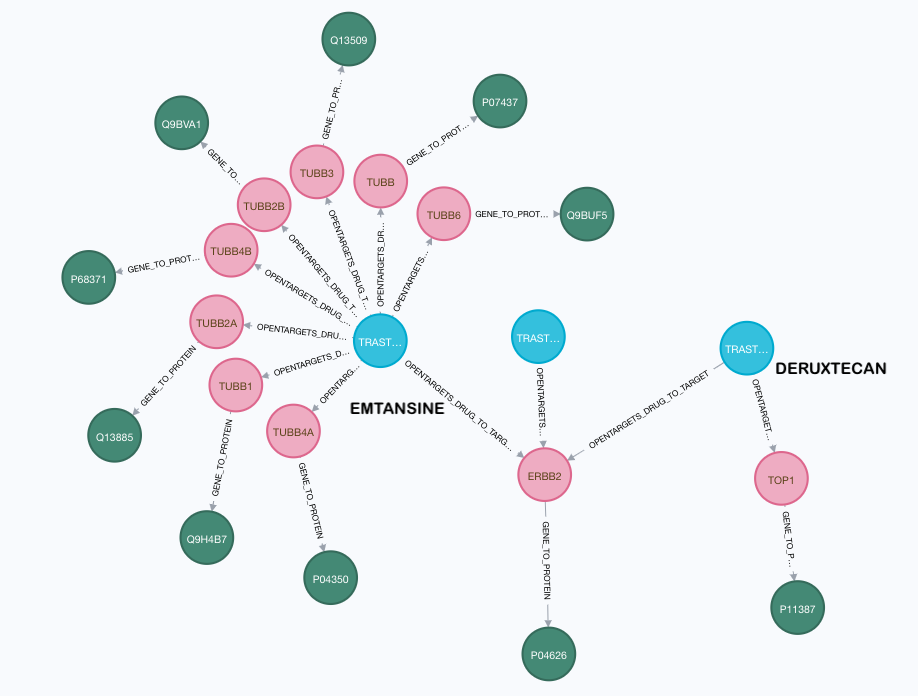

In [163]:
from IPython.display import Image
Image(filename = "herceptin_genes.png", width = 800)

In [181]:
query="""
match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(drug.label) contains "trastuzumab"
match (drug)-[r4]->(disease:Disease)
set disease.name = disease.label
return drug.label, gene.name, disease.name, 
        l1.name as term1, lt.predicate as pred1, l2.name as term2 
"""
df_complex= query_to_df(query)
df_complex


match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(drug.label) contains "trastuzumab"
match (drug)-[r4]->(disease:Disease)
set disease.name = disease.label
return drug.label, gene.name, disease.name, 
        l1.name as term1, lt.predicate as pred1, l2.name as term2 



,drug.label,gene.name,disease.name,term1,pred1,term2
0,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,INTERACTS_WITH,BRAF
1,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,INTERACTS_WITH,BRAF gene
2,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,COEXISTS_WITH,MMP9
3,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,COEXISTS_WITH,MMP9 gene
4,TRASTUZUMAB EMTANSINE,ERBB2,neoplasm (disease),ERBB2,COEXISTS_WITH,MLN
...,...,...,...,...,...,...
33158,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,AKT1
33159,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,Proto-Oncogene Proteins c-akt
33160,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,"Antibodies, Bispecific"
33161,TRASTUZUMAB,ERBB2,breast carcinoma,ERBB2,INTERACTS_WITH,Agent


In [ ]:
# need to explore the tabel above!

In [186]:
# get lit triples for herceptin target genes

# WHY no results?

gene_target = list(set(df['GeneTarget']))
query="""
match (gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where gene in {}
return gene.name, 
        l1.name as term1, lt.predicate as pred1,l2.name as term2 
""".format(gene_target)
df_easy= query_to_df(query)
df_easy


match (gene:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where gene in ['TOP1', 'TUBB6', 'TUBB2A', 'TUBB', 'TUBB4A', 'ERBB2', 'TUBB2B', 'TUBB4B', 'TUBB3', 'TUBB1']
return gene.name, 
        l1.name as term1, lt.predicate as pred1,l2.name as term2 



""


In [ ]:
# testing this network in browser
query="""
match (drug:Drug)-[r1:OPENTARGETS_DRUG_TO_TARGET]->(gene:Gene)<-[r2:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(drug.label) contains "trastuzumab"
match (drug)-[r4]->(disease:Disease)
set disease.name = disease.label
return disease, r4, drug, r1,gene, r2, lt,l1,l2
"""

In [149]:
# tidy lit
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
WHERE gwas.trait =~ "(?i).*igf-1.*" 
AND gs.pval < 1e-05 
AND triple.predicate IN ['CAUSES'] 
WITH gwas, triple, lit, gs 
MATCH (gwas)-[gl:GWAS_TO_LITERATURE]-(lit) 
RETURN gwas {.id, .trait}, gs {.pval, .localCount}, triple {.id, .predicate}, lit {.pubmed_id} LIMIT 500

SyntaxError: invalid syntax (<ipython-input-149-bae1dcbe7a12>, line 2)